In [73]:
# -*- coding: utf-8 -*-

import os
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import cProfile
import colorsys

In [2]:
def load_exposures(source_dir, channel=0):
    filenames = []
    exposure_times = []
    f = open(os.path.join(source_dir, 'image_list.txt'))
    for line in f:
        if (line[0] == '#'):
            continue
        (filename, exposure, *rest) = line.split()
        filenames += [filename]
        exposure_times += [exposure]
    
    img_list = [cv2.imread(os.path.join(source_dir, f), 1) for f in filenames]
    img_list = [img[:,:,channel] for img in img_list]
    exposure_times = np.array(exposure_times, dtype=np.float32)

    return (img_list, exposure_times)


In [3]:
def hdr_debvec(img_list, exposure_times):
    B = [math.log(e,2) for e in exposure_times]
    l = 50
    w = [z if z <= 0.5*255 else 255-z for z in range(256)]

    small_img = [cv2.resize(img, (10, 10)) for img in img_list]
    Z = [img.flatten() for img in small_img]

    
    print(np.shape(Z))
    
    return response_curve_solver(Z, B, l, w)


In [4]:
def response_curve_solver(Z, B, l, w):
    n = 256
    A = np.zeros(shape=(np.size(Z, 0)*np.size(Z, 1)+n+1, n+np.size(Z, 1)), dtype=np.float32)
    b = np.zeros(shape=(np.size(A, 0), 1), dtype=np.float32)

    # Include the data−fitting equations
    k = 0
    for i in range(np.size(Z, 1)):
        for j in range(np.size(Z, 0)):
            z = Z[j][i]
            wij = w[z]
            A[k][z] = wij
            A[k][n+i] = -wij
            b[k] = wij*B[j]
            k += 1
    
    # Fix the curve by setting its middle value to 0
    A[k][128] = 1
    k += 1

    # Include the smoothness equations
    for i in range(n-1):
        A[k][i]   =    l*w[i+1]
        A[k][i+1] = -2*l*w[i+1]
        A[k][i+2] =    l*w[i+1]
        k += 1

    print(np.shape(A))
    print(np.shape(b))
    
    # Solve the system using SVD
    x = np.linalg.lstsq(A, b)[0]
    g = x[:256]
    lE = x[256:]

    return g, lE


In [5]:
# Loading exposure images into a list
img_list_b, exposure_times = load_exposures('test', 0)
img_list_g, exposure_times = load_exposures('test', 1)
img_list_r, exposure_times = load_exposures('test', 2)

gb, _ = hdr_debvec(img_list_b, exposure_times)
gg, _ = hdr_debvec(img_list_g, exposure_times)
gr, _ = hdr_debvec(img_list_r, exposure_times)

#print(x)


(16, 100)
(1857, 356)
(1857, 1)
(16, 100)
(1857, 356)
(1857, 1)
(16, 100)
(1857, 356)
(1857, 1)


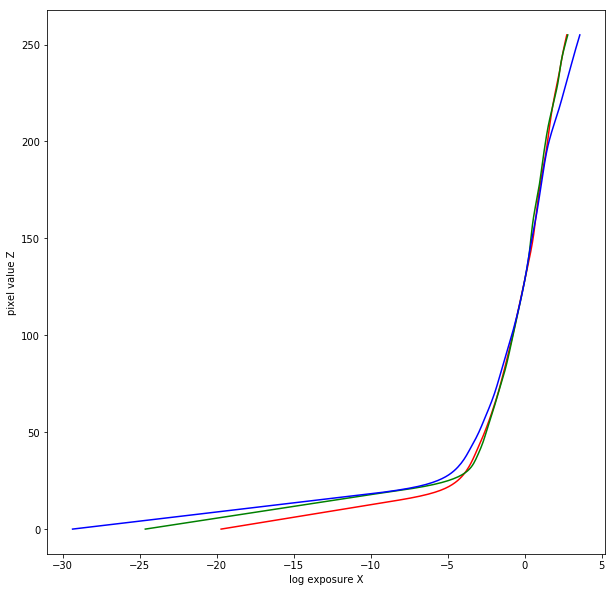

In [6]:
plt.figure(figsize=(10,10))
plt.plot(gr,range(256), 'r')
plt.plot(gg,range(256), 'g')
plt.plot(gb,range(256), 'b')
plt.ylabel('pixel value Z')
plt.xlabel('log exposure X')
plt.show()

In [7]:
def construct_radiance_map(g, Z, ln_t, w):
    acc_E = [0]*len(Z[0])
    ln_E = [0]*len(Z[0])
    
    pixels, imgs = len(Z[0]), len(Z)
    for i in range(pixels):
        acc_w = 0
        for j in range(imgs):
            z = Z[j][i]
            acc_E[i] += w[z]*(g[z] - ln_t[j])
            acc_w += w[z]
        ln_E[i] = acc_E[i]/acc_w
        acc_w = 0
    
    return ln_E

In [8]:
w = [z if z <= 0.5*255 else 255-z for z in range(256)]
Zb = [img.flatten().tolist() for img in img_list_b]
Zg = [img.flatten().tolist() for img in img_list_g]
Zr = [img.flatten().tolist() for img in img_list_r]

print(np.shape(Zb[0]))
cProfile.run('Eb = construct_radiance_map(gb, Zb, exposure_times, w)')
cProfile.run('Eg = construct_radiance_map(gg, Zg, exposure_times, w)')
cProfile.run('Er = construct_radiance_map(gr, Zr, exposure_times, w)')


(393216,)
         8 function calls in 29.807 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1   29.775   29.775   29.775   29.775 <ipython-input-7-2c6cc92d45a0>:1(construct_radiance_map)
        1    0.032    0.032   29.807   29.807 <string>:1(<module>)
        1    0.000    0.000   29.807   29.807 {built-in method builtins.exec}
        4    0.000    0.000    0.000    0.000 {built-in method builtins.len}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}


         8 function calls in 27.977 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1   27.934   27.934   27.934   27.934 <ipython-input-7-2c6cc92d45a0>:1(construct_radiance_map)
        1    0.043    0.043   27.977   27.977 <string>:1(<module>)
        1    0.000    0.000   27.977   27.977 {built-in method builtins.exec}
        4    0.000    0.00

In [146]:
E = np.asarray([Eb, Eg, Er])

vfunc = np.vectorize(lambda x:math.exp(x))
img_size = img_list_b[0].shape

print(E.shape, img_size)

for i in range(3):
    E[i] = vfunc(E[i])
    
bE = np.reshape(E[0], img_size)
gE = np.reshape(E[1], img_size)
rE = np.reshape(E[2], img_size)

print(np.shape(rE))

#im_color = cv2.applyColorMap(rE, cv2.COLORMAP_BONE)

#cv2.imshow('t',rE[0])
#cv2.waitKey(0)

(3, 393216, 1) (768, 512)
(768, 512)


In [147]:
hdr = np.zeros((rE.shape[0], rE.shape[1], 3), 'float32')
hdr[..., 0] = bE
hdr[..., 1] = gE
hdr[..., 2] = rE

In [148]:

print(hdr.max())

1.59511


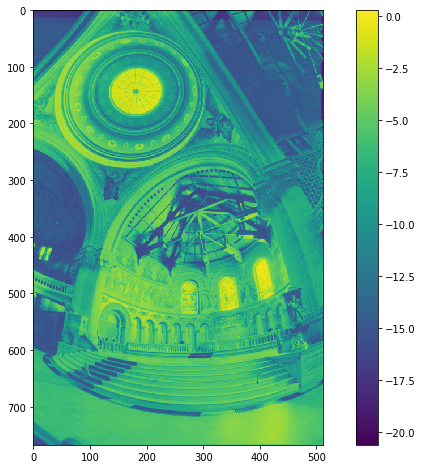

In [152]:
uhdr = cv2.cvtColor(hdr, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(12,8))
plt.imshow(np.log(uhdr))
plt.colorbar()
plt.show()
#uhdr = [channel/channel.max() for channel in hdr]
#uhdr -= uhdr.min()
#uhdr *= 255/uhdr.max()
#uhdr = np.array(uhdr).astype(np.uint8)
#print(uhdr.max(),uhdr.shape, uhdr.dtype)
#im_color = cv2.applyColorMap(uhdr, cv2.COLORMAP_JET)

In [150]:
print(hdr.shape, hdr.dtype)
image = np.zeros((hdr.shape[0], hdr.shape[1], 3), 'float32')
image[..., 0] = hdr[..., 2]
image[..., 1] = hdr[..., 1]
image[..., 2] = hdr[..., 0]

f = open("xxx.hdr", "wb")
f.write(b"#?RADIANCE\n# Made with Python & Numpy\nFORMAT=32-bit_rle_rgbe\n\n")
header = "-Y {0} +X {1}\n".format(image.shape[0], image.shape[1]) 
f.write(bytes(header, encoding='utf-8'))

brightest = np.maximum(np.maximum(image[...,0], image[...,1]), image[...,2])
mantissa = np.zeros_like(brightest)
exponent = np.zeros_like(brightest)
np.frexp(brightest, mantissa, exponent)
scaled_mantissa = mantissa * 256.0 / brightest
rgbe = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8)
rgbe[...,0:3] = np.around(image[...,0:3] * scaled_mantissa[...,None])
rgbe[...,3] = np.around(exponent + 128)

rgbe.flatten().tofile(f)
f.close()

(768, 512, 3) float32


In [115]:
cv2.imshow('fg',im_color)
cv2.waitKey(0)


255

In [23]:
tonemap1 = cv2.createTonemapDurand(gamma=2.2)
res_debvec = tonemap1.process(hdr.copy())

In [25]:
res_debvec_8bit = np.clip(res_debvec*255, 0, 255).astype('uint8')
cv2.imwrite('g.png', res_debvec_8bit)


True